# March Madness Seed Predictions


### Laila Shaaban

In [1]:
#Imports here
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf

## 1. Introduction

In this analysis, the primary research goal is to build a predictive model that will effectively predict the seed in the NCAA March Madness tournament, `SEED`, for new datasets. To look deeper into this goal, we will take a look at the following explanatory variables: a team's conference affiliation, `CONF`; the number of games won, `W`; three-point shooting percentage allowed, `3P_D`; offensive rebound rate, `ORB`; and power rating (chance of beating an average Division I team), `BARTHAG`. Our secondary research goal is to use our model in hopes of yielding reliable interpretative insights about the nature of the relationship between the variables in the dataset. This analysis would be particularly useful for college basketball teams, coaches, and sports analysts who are interested in understanding the factors that contribute to a team's performance and likelihood of success in NCAA Division I basketball. Stakeholders including sports analysts, media outlets, fans, sports betting communities, and fantasy sports communities could all benefit from this in predicting outcomes.

## 2. Dataset Discussion

From Kaggle, I got the 'cbb.csv' dataset, which can be found here: https://www.kaggle.com/datasets/andrewsundberg/college-basketball-dataset. I downloaded this csv file on 2/13/24.

The dataset includes information from the Division I college basketball seasons from 2013 to 2023 (2020 was not included because of the COVID-19 epidemic, which prevented postseason play). This data was taken from http://barttorvik.com/trank.php#. Each row provides detailed information about a team's performance metrics, conference affiliation, postseason outcomes, and other relevant attributes. Data collection likely involved official NCAA records, sports analytics databases, and possibly direct data collection efforts. While the dataset offers comprehensive insights into team performance, it may lack certain nuanced aspects such as player-specific statistics or qualitative factors like coaching strategies. Despite these limitations, the dataset enables analysis of key variables such as `CONF` (conference affiliation), `W` (number of wins), etc.


In [2]:
# Drop NA values and display first 5 rows
dforiginal = pd.read_csv('cbb.csv')
dforiginal.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016
1,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,...,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1.0,2015
2,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,...,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3.0,2018
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,...,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3.0,2019
4,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,...,26.9,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1.0,2017


In [3]:
# Number of rows
print('Number of Rows =',dforiginal.shape[0])

Number of Rows = 3523


## 3. Dataset Cleaning

Since all of the data types correspond correctly to the variables' input types, there doesn't seem to be any implicit missing values. Dropping all NA values did show that there were explicit missing values, which led us to drop 2843 rows. Following this, I dropped the conferences that had less than 10 observations and didn't contribute effectively to my analysis, which dropped 18 rows. Upon forming plots to display the relationship between the variables, there didn't seem to be any obvious outliers to remove, so I left the data as is at that point. Since the existence of outliers, if any, didn't seem to affect the ability to predict on new datasets, leaving them was the right choice to keep the integrity of our data.

In [4]:
# Isolating explanatory variables
dforiginal = dforiginal[['SEED','BARTHAG','W','CONF','3P_D','ORB']]
dforiginal.head()

,SEED,BARTHAG,W,CONF,3P_D,ORB
0,1.0,0.9531,33,ACC,36.2,40.7
1,1.0,0.9758,36,B10,37.5,32.1
2,3.0,0.9375,33,B10,33.2,25.5
3,3.0,0.9696,31,B12,29.7,27.4
4,1.0,0.9728,37,WCC,29.0,30.0


In [5]:
# Checking for implicit missing values
dforiginal.dtypes

SEED       float64
BARTHAG    float64
W            int64
CONF        object
3P_D       float64
ORB        float64
dtype: object

In [6]:
# Dropping na values
df = dforiginal.dropna()
print('Number of Rows Dropped After Removing Explicit Missing Values:', len(dforiginal)-len(df))
df.head()

Number of Rows Dropped After Removing Explicit Missing Values: 2843


,SEED,BARTHAG,W,CONF,3P_D,ORB
0,1.0,0.9531,33,ACC,36.2,40.7
1,1.0,0.9758,36,B10,37.5,32.1
2,3.0,0.9375,33,B10,33.2,25.5
3,3.0,0.9696,31,B12,29.7,27.4
4,1.0,0.9728,37,WCC,29.0,30.0


In [7]:
# Dropping 'CONF' values with less than 10 observations in the dataset
value_counts = df['CONF'].value_counts()
values_to_drop = value_counts[value_counts < 10].index
dfcleaned = df[~df['CONF'].isin(values_to_drop)]
print('Number of Dropped Rows that Had <10 Observations:', len(df)-len(dfcleaned))

Number of Dropped Rows that Had <10 Observations: 18


In [8]:
# Renaming the data df to allow for easier use later on
df = dfcleaned
df.head()

,SEED,BARTHAG,W,CONF,3P_D,ORB
0,1.0,0.9531,33,ACC,36.2,40.7
1,1.0,0.9758,36,B10,37.5,32.1
2,3.0,0.9375,33,B10,33.2,25.5
3,3.0,0.9696,31,B12,29.7,27.4
4,1.0,0.9728,37,WCC,29.0,30.0


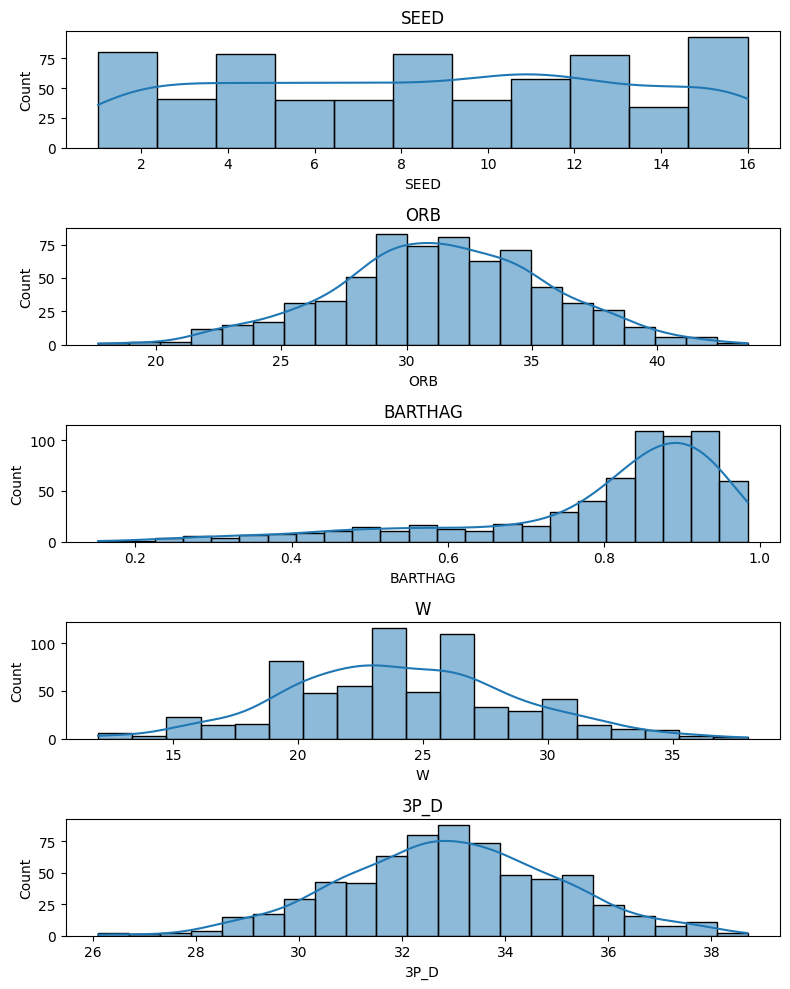

In [9]:
# List of variables
variables = ['SEED', 'ORB', 'BARTHAG', 'W', '3P_D']

# Create subplots
fig, axes = plt.subplots(len(variables), 1, figsize=(8, 10))

# Plot histograms for each variable
for i, variable in enumerate(variables):
    sns.histplot(df[variable], kde=True, ax=axes[i])
    axes[i].set_title(variable)

# Adjust layout
plt.tight_layout()
plt.show()

## 4. Preliminary Analysis

In this section, we took the data and split it into training/testing datasets. In doing this, we can test the fit/predictability of the model for future datasets. After splitting, we fit a model using the response variable, `SEED`, and the explanatory variables. Following this, we plotted a residuals vs fitted values plot, which showed that we did not meet the linearity assumption. After coming to this realization, we attempted to transform the `SEED` variable in multiple ways. Transforming `SEED` brought us further from the linearity assumption, so we will keep the original model.

Following the transformed model attempts, we plotted every pair of numerical and categorical explanatory variables against the `SEED` response variable. After doing this, we determined that the plots putting `ORB` and `BARTHAG` against `CONF` seemed to have large interactions in how they affect `SEED`.

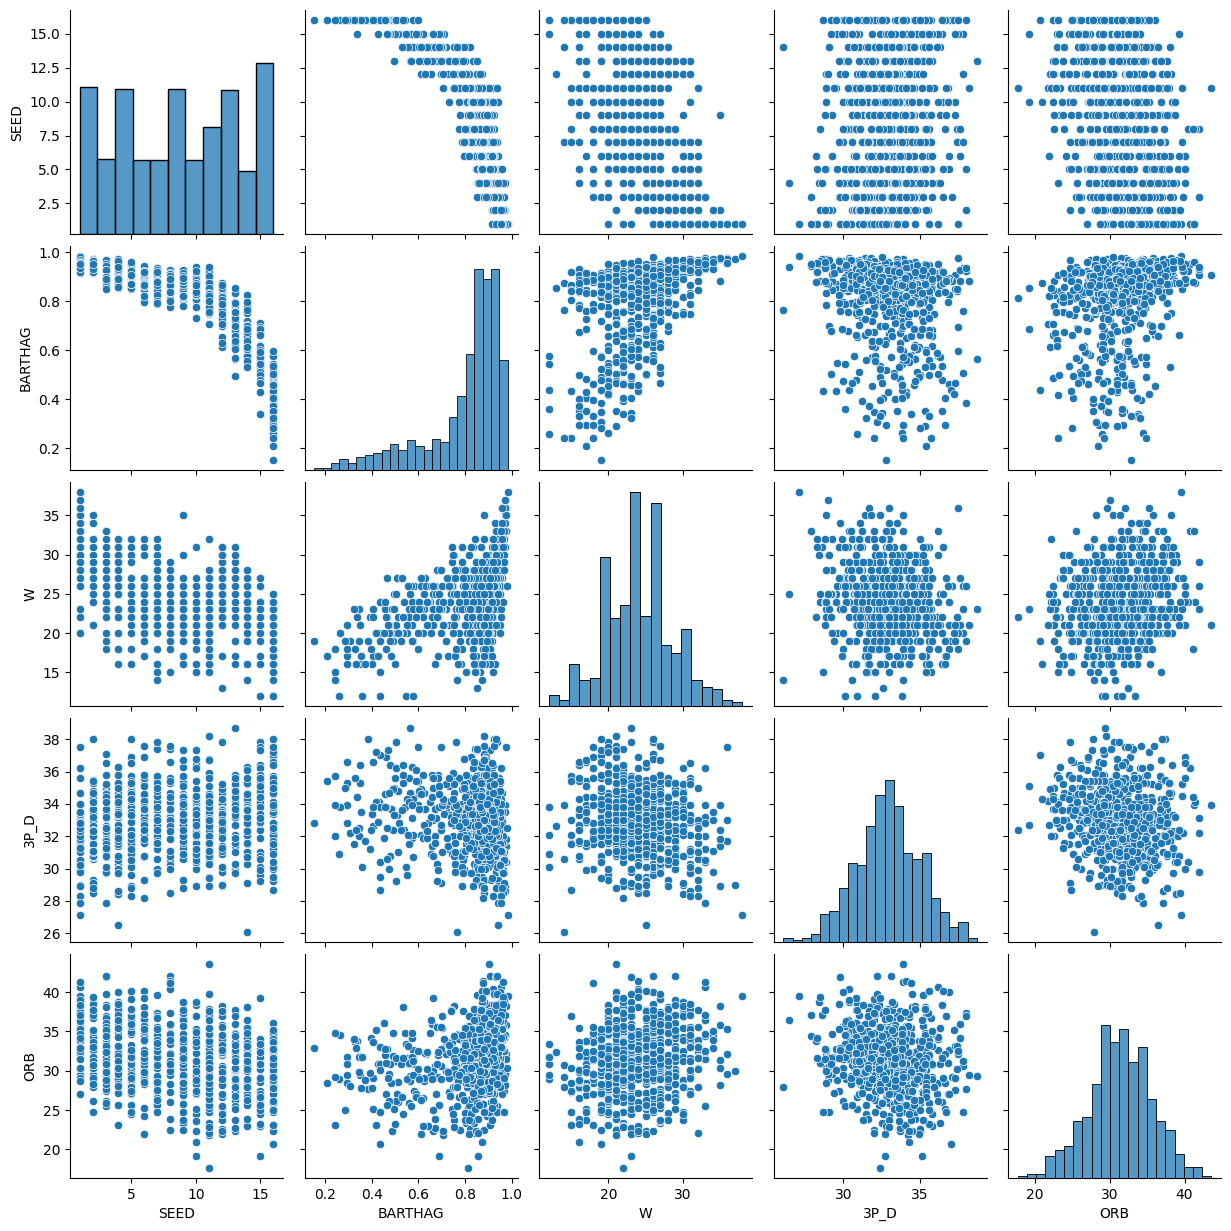

In [10]:
# Pairplot of all numerical variables
sns.pairplot(df)
plt.show()

In [11]:
# Renaming 3P_D to PD to avoid error in model
df['PD'] = df['3P_D']
df.drop('3P_D', axis=1, inplace=True)
df.head()

,SEED,BARTHAG,W,CONF,ORB,PD
0,1.0,0.9531,33,ACC,40.7,36.2
1,1.0,0.9758,36,B10,32.1,37.5
2,3.0,0.9375,33,B10,25.5,33.2
3,3.0,0.9696,31,B12,27.4,29.7
4,1.0,0.9728,37,WCC,30.0,29.0


In [12]:
# Fitting model
model = smf.ols(formula = 'SEED ~ W + ORB + CONF + PD + BARTHAG', data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   SEED   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     81.85
Date:                Sun, 31 Mar 2024   Prob (F-statistic):          2.03e-203
Time:                        22:04:57   Log-Likelihood:                -1403.9
No. Observations:                 662   AIC:                             2876.
Df Residuals:                     628   BIC:                             3029.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       25.0720      1.870     13.405      0.000      21.399      28.745
CONF[T.ACC]     -2.5431      0.467     -5.447      0.000      -3.460      -1.626
CONF[T.AE]       2.9318      0.795      3.688      0.000       1.371       4.493
CONF[T.Amer]    -1.1628      0.569     -2.045      0.041      -2.279      -0.046
CONF[T.B10]     -2.6261      0.461     -5.695      0.000      -3.532      -1.721
CONF[T.B12]     -3.4783      0.474     -7.334      0.000      -4.410      -2.547
CONF[T.BE]      -2.4058      0.477     -5.039      0.000      -3.343      -1.468
CONF[T.BSky]     2.0435      0.808      2.528      0.012       0.456       3.631
CONF[T.BSth]     1.9212      0.812      2.365      0.018       0.326       3.517
CONF[T.BW]       2.0126      0.797      2.525      0.012       0.447       3.578
CONF[T.CAA]      2.4216      0.785      3.084      0.002       0.880       3.964
CONF[T.CUSA]     2.4462      0.767      3.190      0.001       0.940       3.952
CONF[T.Horz]     2.6170      0.807      3.241      0.001       1.031       4.203
CONF[T.MAAC]     2.0268      0.788      2.572      0.010       0.479       3.574
CONF[T.MAC]      1.8702      0.775      2.414      0.016       0.349       3.392
CONF[T.MEAC]     1.1145      0.929      1.200      0.231      -0.710       2.939
CONF[T.MVC]      1.1931      0.674      1.771      0.077      -0.130       2.516
CONF[T.MWC]     -0.2733      0.555     -0.492      0.623      -1.363       0.817
CONF[T.NEC]      0.4273      0.913      0.468      0.640      -1.366       2.220
CONF[T.OVC]      1.5788      0.768      2.057      0.040       0.071       3.086
CONF[T.P12]     -1.7084      0.496     -3.443      0.001      -2.683      -0.734
CONF[T.Pat]      2.0423      0.794      2.571      0.010       0.482       3.602
CONF[T.SB]       2.7135      0.759      3.576      0.000       1.223       4.204
CONF[T.SC]       2.4966      0.777      3.212      0.001       0.970       4.023
CONF[T.SEC]     -2.4081      0.482     -4.997      0.000      -3.354      -1.462
CONF[T.SWAC]     0.3248      0.928      0.350      0.727      -1.498       2.148
CONF[T.Slnd]     3.1399      0.811      3.874      0.000       1.548       4.731
CONF[T.Sum]      1.8921      0.794      2.382      0.018       0.332       3.452
CONF[T.WAC]      3.5049      0.778      4.502      0.000       1.976       5.034
CONF[T.WCC]     -1.3697      0.614     -2.230      0.026      -2.576      -0.163
W               -0.3352      0.023    -14.522      0.000      -0.381      -0.290
ORB             -0.0388      0.022     -1.799      0.073      -0.081       0.004
PD               0.0410      0.042      0.976      0.329      -0.041       0.123
BARTHAG         -9.5360      1.243     -7.671      0.000     -11.977      -7.095
==============================================================================
Omnibus

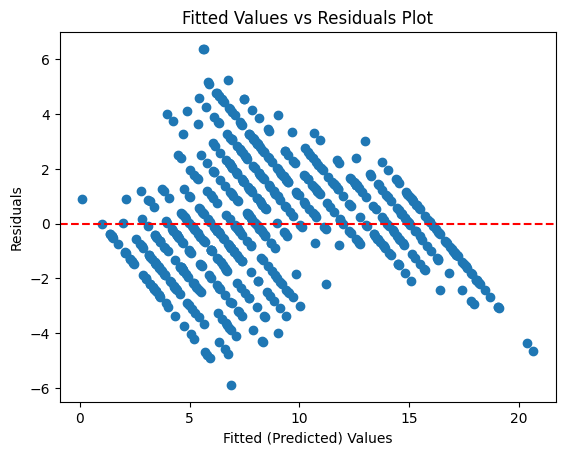

In [13]:
# Fitted Values vs Residuals Plot
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('Fitted (Predicted) Values')
plt.ylabel('Residuals')
plt.title('Fitted Values vs Residuals Plot')
plt.show()

Since the residuals above and below the line are uneven, the linearity assumption is not met here.

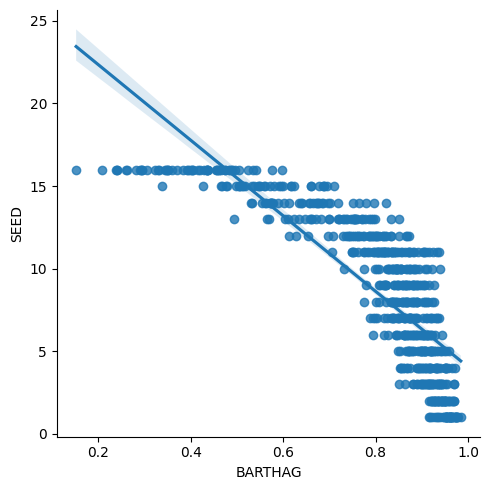

In [14]:
# Checking where the problem is
sns.lmplot(x='BARTHAG', y = 'SEED', data = df)
plt.show()

In [15]:
# Transforming SEED
df['SEED2'] = np.sqrt(df['SEED'])
df.head()

,SEED,BARTHAG,W,CONF,ORB,PD,SEED2
0,1.0,0.9531,33,ACC,40.7,36.2,1.000000
1,1.0,0.9758,36,B10,32.1,37.5,1.000000
2,3.0,0.9375,33,B10,25.5,33.2,1.732051
3,3.0,0.9696,31,B12,27.4,29.7,1.732051
4,1.0,0.9728,37,WCC,30.0,29.0,1.000000


In [16]:
# Refitting with SEED2
model2 = smf.ols(formula = 'SEED2 ~ W + ORB + CONF + PD + BARTHAG', data = df).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  SEED2   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     57.39
Date:                Sun, 31 Mar 2024   Prob (F-statistic):          4.50e-166
Time:                        22:04:57   Log-Likelihood:                -396.17
No. Observations:                 662   AIC:                             860.3
Df Residuals:                     628   BIC:                             1013.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.7969      0.408     14.202      0.000       4.995       6.598
CONF[T.ACC]     -0.6018      0.102     -5.906      0.000      -0.802      -0.402
CONF[T.AE]       0.4261      0.173      2.456      0.014       0.085       0.767
CONF[T.Amer]    -0.2345      0.124     -1.889      0.059      -0.478       0.009
CONF[T.B10]     -0.6008      0.101     -5.970      0.000      -0.798      -0.403
CONF[T.B12]     -0.7930      0.104     -7.662      0.000      -0.996      -0.590
CONF[T.BE]      -0.5520      0.104     -5.298      0.000      -0.757      -0.347
CONF[T.BSky]     0.2661      0.176      1.508      0.132      -0.080       0.612
CONF[T.BSth]     0.2615      0.177      1.475      0.141      -0.087       0.610
CONF[T.BW]       0.2488      0.174      1.430      0.153      -0.093       0.590
CONF[T.CAA]      0.3573      0.171      2.085      0.037       0.021       0.694
CONF[T.CUSA]     0.4140      0.167      2.474      0.014       0.085       0.743
CONF[T.Horz]     0.3692      0.176      2.095      0.037       0.023       0.715
CONF[T.MAAC]     0.2088      0.172      1.214      0.225      -0.129       0.547
CONF[T.MAC]      0.2943      0.169      1.741      0.082      -0.038       0.626
CONF[T.MEAC]     0.0928      0.203      0.457      0.647      -0.305       0.491
CONF[T.MVC]      0.2091      0.147      1.422      0.155      -0.080       0.498
CONF[T.MWC]     -0.0542      0.121     -0.447      0.655      -0.292       0.184
CONF[T.NEC]     -0.0925      0.199     -0.464      0.643      -0.484       0.299
CONF[T.OVC]      0.2240      0.168      1.337      0.182      -0.105       0.553
CONF[T.P12]     -0.3978      0.108     -3.673      0.000      -0.610      -0.185
CONF[T.Pat]      0.2453      0.173      1.415      0.158      -0.095       0.586
CONF[T.SB]       0.3758      0.166      2.269      0.024       0.051       0.701
CONF[T.SC]       0.4406      0.170      2.597      0.010       0.107       0.774
CONF[T.SEC]     -0.5308      0.105     -5.047      0.000      -0.737      -0.324
CONF[T.SWAC]    -0.0867      0.203     -0.428      0.669      -0.485       0.311
CONF[T.Slnd]     0.5023      0.177      2.840      0.005       0.155       0.850
CONF[T.Sum]      0.2410      0.173      1.390      0.165      -0.099       0.581
CONF[T.WAC]      0.5738      0.170      3.377      0.001       0.240       0.907
CONF[T.WCC]     -0.3852      0.134     -2.873      0.004      -0.648      -0.122
W               -0.0787      0.005    -15.623      0.000      -0.089      -0.069
ORB             -0.0087      0.005     -1.843      0.066      -0.018       0.001
PD               0.0150      0.009      1.635      0.103      -0.003       0.033
BARTHAG         -1.3274      0.271     -4.893      0.000      -1.860      -0.795
==============================================================================
Omnibus

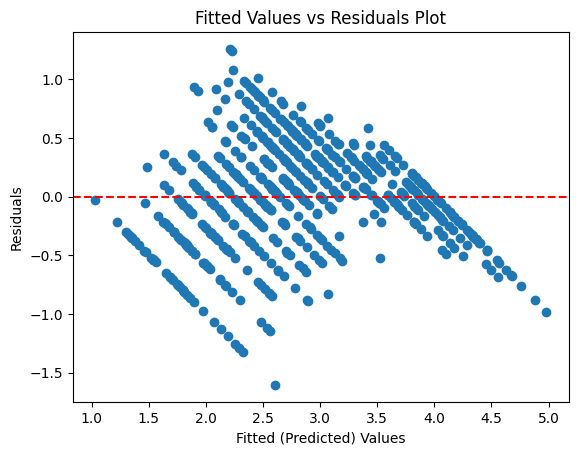

In [17]:
# Fitted Values vs Residuals Plot
plt.scatter(model2.fittedvalues, model2.resid)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('Fitted (Predicted) Values')
plt.ylabel('Residuals')
plt.title('Fitted Values vs Residuals Plot')
plt.show()

Transforming `SEED` brought us further from the linearity assumption, so we will keep the original model.

In [18]:
# Removing SEED2
df.drop('SEED2', axis = 1, inplace = True)
df.head()

,SEED,BARTHAG,W,CONF,ORB,PD
0,1.0,0.9531,33,ACC,40.7,36.2
1,1.0,0.9758,36,B10,32.1,37.5
2,3.0,0.9375,33,B10,25.5,33.2
3,3.0,0.9696,31,B12,27.4,29.7
4,1.0,0.9728,37,WCC,30.0,29.0


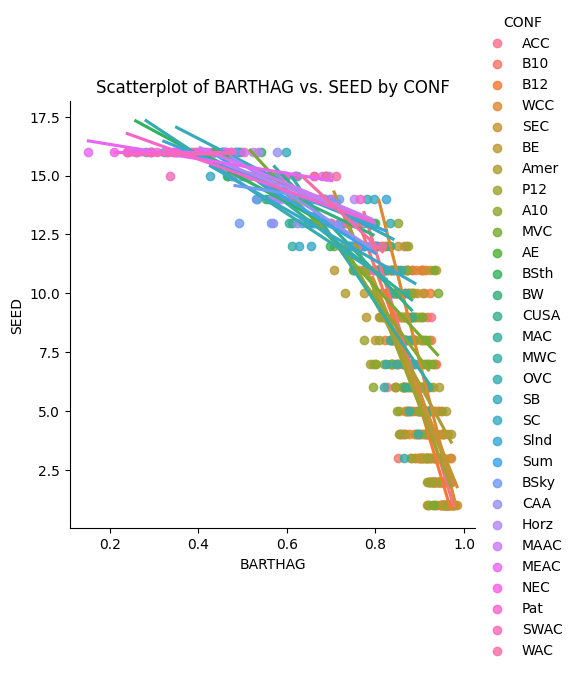

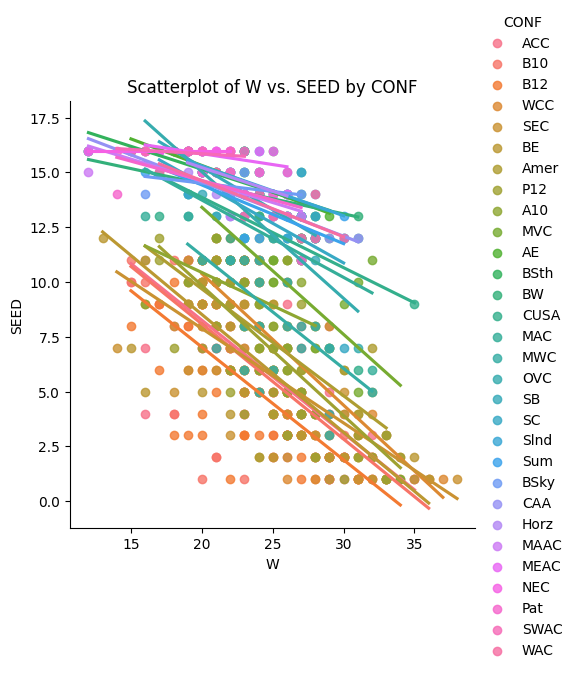

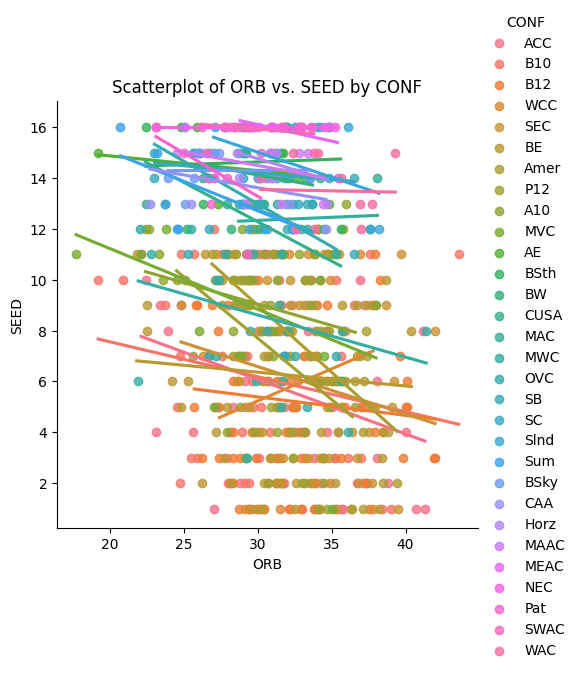

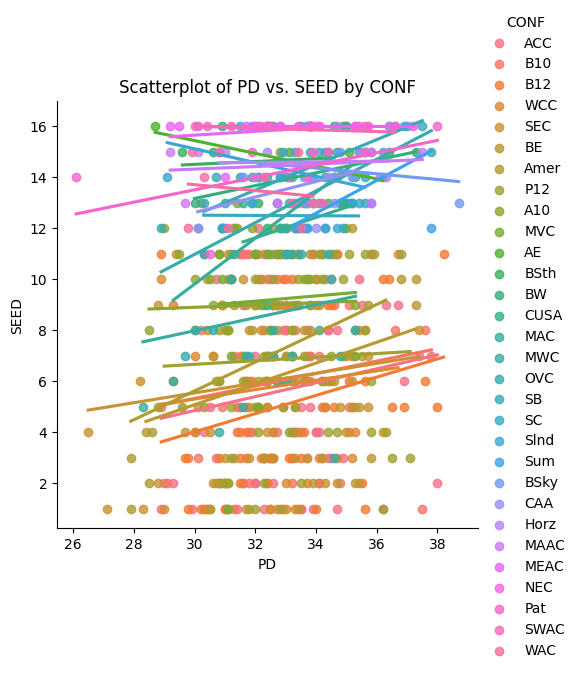

In [19]:
# Scatterplot for BARTHAG and SEED based on CONF
sns.lmplot(x = 'BARTHAG', y = 'SEED', hue = 'CONF', data = df, ci = False)
plt.xlabel('BARTHAG')
plt.ylabel('SEED')
plt.title('Scatterplot of BARTHAG vs. SEED by CONF')
plt.show()
# Scatterplot for W and SEED based on CONF
sns.lmplot(x = 'W', y = 'SEED', hue = 'CONF', data = df, ci = False)
plt.xlabel('W')
plt.ylabel('SEED')
plt.title('Scatterplot of W vs. SEED by CONF')
plt.show()
# Scatterplot for ORB and SEED based on CONF
sns.lmplot(x = 'ORB', y = 'SEED', hue = 'CONF', data = df, ci = False)
plt.xlabel('ORB')
plt.ylabel('SEED')
plt.title('Scatterplot of ORB vs. SEED by CONF')
plt.show()
# Scatterplot for PD and SEED based on CONF
sns.lmplot(x = 'PD', y = 'SEED', hue = 'CONF', data = df, ci = False)
plt.xlabel('PD')
plt.ylabel('SEED')
plt.title('Scatterplot of PD vs. SEED by CONF')
plt.show()

The plots putting `ORB` and `BARTHAG` against `CONF` seem to have large interactions in how they affect `SEED`. We can conclude this because the slopes vary for the different conferences in these two plots.

## 5. Predictive Models

In this section, we created a features matrix and a target array. Following the creation of these two, we split them into training and test datasets. Then, we z-score scaled the training dataset and test dataset numerical variables using the training sataset column means and standard devations.

In [20]:
# Splitting the dataframe using a test size of 20% and a random state of 207
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
print('Checking Test is 20% of OG Dataset:', (len(df_test)/len(df)) * 100, '%')
df_train.head()

Checking Test is 20% of OG Dataset: 20.090634441087612 %


,SEED,BARTHAG,W,CONF,ORB,PD
18,2.0,0.9592,29,ACC,38.8,32.0
2239,13.0,0.6822,22,MAAC,29.2,35.8
2386,11.0,0.9148,19,SEC,27.2,29.4
2178,10.0,0.8473,20,B10,35.3,32.5
2040,2.0,0.9648,30,ACC,34.3,30.8


In [21]:
# Training features matrix
X_train = df_train.drop(columns=['SEED'])
X_train.head()

,BARTHAG,W,CONF,ORB,PD
18,0.9592,29,ACC,38.8,32.0
2239,0.6822,22,MAAC,29.2,35.8
2386,0.9148,19,SEC,27.2,29.4
2178,0.8473,20,B10,35.3,32.5
2040,0.9648,30,ACC,34.3,30.8


In [22]:
# Training target Array
y_train = df_train['SEED']
y_train.head()

18       2.0
2239    13.0
2386    11.0
2178    10.0
2040     2.0
Name: SEED, dtype: float64

In [23]:
# Test features matrix
X_test = df_test.drop(columns=['SEED'])
X_test.head()

,BARTHAG,W,CONF,ORB,PD
2317,0.8252,21,P12,24.5,32.6
2850,0.7579,27,WAC,32.6,29.8
2462,0.9343,24,SEC,31.5,28.8
2352,0.8513,21,P12,33.6,32.0
2255,0.4286,20,NEC,31.0,34.1


In [24]:
# Test target array
y_test = df_test['SEED']
y_test.head()

2317    10.0
2850    12.0
2462     2.0
2352    10.0
2255    16.0
Name: SEED, dtype: float64

In [25]:
# Selecting numerical variables
X_train_num = X_train.select_dtypes(include='number')
X_test_num = X_test.select_dtypes(include='number')

### 5.1 Non-Regularized Linear Regression Full Model

In this section, we fit the non-regularized linear regression full model and got a test $R^2$ of 0.67.

In [26]:
# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_train_num, y_train)

LinearRegression()

In [27]:
# Predict on the test set using transformed variables
y_pred = model.predict(X_test_num)

In [28]:
# Calculate R^2 for the transformed model
r2 = r2_score(y_test, y_pred)

In [29]:
# Printing out test dataset R^2
print("Test dataset R^2:", r2)

Test dataset R^2: 0.6744883505861061


### 5.2 Non-Regularized Linear Regression Full Model with Interaction Terms

In this section, we fit the non-regularized linear regression full model with interaction terms and got a test $R^2$ of 0.79.

In [30]:
# Fitting interaction model
interactionmodel = smf.ols(formula = 'SEED ~ W + ORB + CONF + PD + BARTHAG + ORB*CONF + BARTHAG*CONF', data = df_train).fit()
interactionmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   SEED   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     34.79
Date:                Sun, 31 Mar 2024   Prob (F-statistic):          1.19e-152
Time:                        22:05:02   Log-Likelihood:                -1008.2
No. Observations:                 529   AIC:                             2200.
Df Residuals:                     437   BIC:                             2593.
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               38.0556      5.667      6.715      0.000      26.917      49.194
CONF[T.ACC]             13.8212      7.175      1.926      0.055      -0.281      27.923
CONF[T.AE]             -14.6202      7.384     -1.980      0.048     -29.132      -0.108
CONF[T.Amer]            -6.8040      7.867     -0.865      0.388     -22.265       8.657
CONF[T.B10]              7.7651      7.354      1.056      0.292      -6.688      22.218
CONF[T.B12]              4.8819      8.705      0.561      0.575     -12.226      21.990
CONF[T.BE]               2.8841      6.828      0.422      0.673     -10.536      16.305
CONF[T.BSky]           -19.3665      9.084     -2.132      0.034     -37.220      -1.513
CONF[T.BSth]           -19.0568      7.846     -2.429      0.016     -34.478      -3.636
CONF[T.BW]             -19.0088      9.516     -1.998      0.046     -37.712      -0.305
CONF[T.CAA]            -17.0063      8.284     -2.053      0.041     -33.287      -0.725
CONF[T.CUSA]            -2.2121     10.205     -0.217      0.828     -22.268      17.844
CONF[T.Horz]           -20.7303     25.834     -0.802      0.423     -71.505      30.044
CONF[T.MAAC]           -16.9415      8.110     -2.089      0.037     -32.881      -1.003
CONF[T.MAC]            -15.0905     10.408     -1.450      0.148     -35.546       5.365
CONF[T.MEAC]           -16.7374     10.207     -1.640      0.102     -36.799       3.324
CONF[T.MVC]            -11.8673      6.906     -1.718      0.086     -25.441       1.706
CONF[T.MWC]             -3.2085      6.961     -0.461      0.645     -16.890      10.473
CONF[T.NEC]            -17.9945      8.516     -2.113      0.035     -34.733      -1.256
CONF[T.OVC]            -11.3976      7.034     -1.620      0.106     -25.221       2.426
CONF[T.P12]              2.6617      7.305      0.364      0.716     -11.695      17.018
CONF[T.Pat]              3.4916     15.672      0.223      0.824     -27.310      34.294
CONF[T.SB]             -13.0437      7.975     -1.636      0.103     -28.717       2.630
CONF[T.SC]             -10.7367     12.934     -0.830      0.407     -36.158      14.684
CONF[T.SEC]             -3.6712      7.892     -0.465      0.642     -19.183      11.840
CONF[T.SWAC]           -19.6873     12.268     -1.605      0.109     -43.799       4.425
CONF[T.Slnd]             2.2724     22.878      0.099      0.921     -42.693      47.238
CONF[T.Sum]            -13.1251      6.995     -1.876      0.061     -26.874       0.623
CONF[T.WAC]            -16.3806     11.877     -1.379      0.169     -39.724       6.962
CONF[T.WCC]             37.3827     13.866      2.696      0.007      10.130      64.636
W                       -0.2344      0.025     -9.384      0.000      -0.284      -0.185
ORB                     -0.0219      0.092     -0.239    

In [31]:
# Fitting prediction on test dataset
y_pred = interactionmodel.predict(X_test)

In [32]:
# Printing test R^2
r2 = r2_score(y_test, y_pred)
print("Test dataset R^2:", r2)

Test dataset R^2: 0.7933549562613444


### 5.3 Backwards Elimination Algorithm

In [33]:
# Current model 
interactionmodel = smf.ols(formula = 'SEED ~ W + ORB + CONF + PD + BARTHAG + ORB*CONF + BARTHAG*CONF', data = df_train).fit()
y_pred = interactionmodel.predict(X_test)
print("Test Dataset R^2:", r2_score(y_test,y_pred))

Test Dataset R^2: 0.7933549562613444


In [34]:
# Removing W
W = smf.ols(formula = 'SEED ~ ORB + CONF + PD + BARTHAG + ORB*CONF + BARTHAG*CONF', data = df_train).fit()
y_pred = W.predict(X_test)
print("Test Dataset R^2:", r2_score(y_test,y_pred))

Test Dataset R^2: 0.7836621772205292


In [35]:
# Removing ORB
ORB = smf.ols(formula = 'SEED ~ W + CONF + PD + BARTHAG + ORB*CONF + BARTHAG*CONF', data = df_train).fit()
y_pred = ORB.predict(X_test)
print("Test Dataset R^2:", r2_score(y_test,y_pred))

Test Dataset R^2: 0.7933549562613602


In [36]:
# Removing CONF
CONF = smf.ols(formula = 'SEED ~ W + ORB + PD + BARTHAG + ORB*CONF + BARTHAG*CONF', data = df_train).fit()
y_pred = CONF.predict(X_test)
print("Test Dataset R^2:", r2_score(y_test,y_pred))

Test Dataset R^2: 0.7933549562613444


In [37]:
# Removing PD
PD = smf.ols(formula = 'SEED ~ W + ORB + CONF + BARTHAG + ORB*CONF + BARTHAG*CONF', data = df_train).fit()
y_pred = PD.predict(X_test)
print("Test Dataset R^2:", r2_score(y_test,y_pred))

Test Dataset R^2: 0.7930630366512651


In [38]:
# Removing BARTHAG
BARTHAG = smf.ols(formula = 'SEED ~ W + ORB + CONF + PD + ORB*CONF + BARTHAG*CONF', data = df_train).fit()
y_pred = BARTHAG.predict(X_test)
print("Test Dataset R^2:", r2_score(y_test,y_pred))

Test Dataset R^2: 0.7933549562613444


In [39]:
# Removing ORB*CONF 
ORBCONF = smf.ols(formula = 'SEED ~ W + ORB + CONF + PD + BARTHAG + BARTHAG*CONF', data = df_train).fit()
y_pred = ORBCONF.predict(X_test)
print("Test Dataset R^2:", r2_score(y_test,y_pred))

Test Dataset R^2: 0.8106019124435745


In [40]:
# Removing BARTHAG*CONF
BARTHAGCONF = smf.ols(formula = 'SEED ~ W + ORB + CONF + PD + BARTHAG + ORB*CONF', data = df_train).fit()
y_pred = BARTHAGCONF.predict(X_test)
print("Test Dataset R^2:", r2_score(y_test,y_pred))

Test Dataset R^2: 0.7402203079473826


In [41]:
# Final Model
ORBCONF = smf.ols(formula = 'SEED ~ W + ORB + CONF + PD + BARTHAG + BARTHAG*CONF', data = df_train).fit()
y_pred = ORBCONF.predict(X_test)
print("Final Model Test R^2:", r2_score(y_test,y_pred))
print(ORBCONF.summary())

Final Model Test R^2: 0.8106019124435745
                            OLS Regression Results                            
Dep. Variable:                   SEED   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     52.06
Date:                Sun, 31 Mar 2024   Prob (F-statistic):          1.55e-172
Time:                        22:05:02   Log-Likelihood:                -1018.5
No. Observations:                 529   AIC:                             2163.
Df Residuals:                     466   BIC:                             2432.
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

## 6. Best Model Discussion

The best model is the one with the highest test $R^2$, which is this model (has test $R^2$ = 0.81):

SEED(hat) = 36.8719 + 15.1433 * CONF[T.ACC] + -16.4527 * CONF[T.AE] + -6.6068 * CONF[T.Amer] + 8.9998 * CONF[T.B10] + 7.3628 * CONF[T.B12] + 4.8305 * CONF[T.BE] + -16.6438 * CONF[T.BSky] + -17.5212 * CONF[T.BSth] + -16.1168 * CONF[T.BW] + -14.7893 * CONF[T.CAA] + -10.0381 * CONF[T.CUSA] + -18.5978 * CONF[T.Horz] + -17.8499 * CONF[T.MAAC] + -12.0328 * CONF[T.MAC] + -18.0726 * CONF[T.MEAC] + -11.3253 * CONF[T.MVC] + -2.3788 * CONF[T.MWC] + -18.2552 * CONF[T.NEC] + -14.9971 * CONF[T.OVC] + 4.9667 * CONF[T.P12] + -14.5778 * CONF[T.Pat] + -14.4358 * CONF[T.SB] + -15.8370 * CONF[T.SC] + -1.8673 * CONF[T.SEC] + -19.5837 * CONF[T.SWAC] + -15.3966 * CONF[T.Slnd] + -16.0506 * CONF[T.Sum] + -15.0014 * CONF[T.WAC] + 45.7179 * CONF[T.WCC] + -0.2242 * W + 0.0179 * ORB + 0.0215 * PD + -28.3645 * BARTHAG + -18.4116 * BARTHAG:CONF[T.ACC] + 25.2764 * BARTHAG:CONF[T.AE] + 6.9001 * BARTHAG:CONF[T.Amer] + -11.5216 * BARTHAG:CONF[T.B10] + -10.6663 * BARTHAG:CONF[T.B12] + -7.0337 * BARTHAG:CONF[T.BE] + 25.0495 * BARTHAG:CONF[T.BSky] + 26.8228 * BARTHAG:CONF[T.BSth] + 23.6157 * BARTHAG:CONF[T.BW] + 21.4543 * BARTHAG:CONF[T.CAA] + 14.0553 * BARTHAG:CONF[T.CUSA] + 28.2957 * BARTHAG:CONF[T.Horz] + 26.6068 * BARTHAG:CONF[T.MAAC] + 15.4711 * BARTHAG:CONF[T.MAC] + 29.1917 * BARTHAG:CONF[T.MEAC] + 15.4132 * BARTHAG:CONF[T.MVC] + 2.7911 * BARTHAG:CONF[T.MWC] + 28.9039 * BARTHAG:CONF[T.NEC] + 20.6738 * BARTHAG:CONF[T.OVC] + -7.0690 * BARTHAG:CONF[T.P12] + 21.5764 * BARTHAG:CONF[T.Pat] + 21.5097 * BARTHAG:CONF[T.SB] + 22.4206 * BARTHAG:CONF[T.SC] + 0.5527 * BARTHAG:CONF[T.SEC] + 32.9858 * BARTHAG:CONF[T.SWAC] + 23.3684 * BARTHAG:CONF[T.Slnd] + 23.2130 * BARTHAG:CONF[T.Sum] + 22.7331 * BARTHAG:CONF[T.WAC] + -49.4585 * BARTHAG:CONF[T.WCC]

An $R^2$ value of 0.81 indicates that approximately 81% of the variability in the `SEED` variable is explained by the independent variables included in the model. This means the model provides a good fit to the test data, capturing a large portion of the variability in `SEED`. Having a good test $R^2$ shows us that the model is effective in predicting a team's seed in the March Madness tournament based on the given set of explanatory variables.

Dropping the interaction term `BARTHAG*CONF` makes the test $R^2$ of the model drop the most, which indicates that it might be overfitting. The drop in model performance suggests that the term was likely overfitting since its inclusion was artifically inflating the model's performance.

In [42]:
# Checking for multicollinearity
df_train[['W','ORB','PD','BARTHAG']].corr()

,W,ORB,PD,BARTHAG
W,1.000000,0.211585,-0.165864,0.491239
ORB,0.211585,1.000000,-0.145028,0.248942
PD,-0.165864,-0.145028,1.000000,-0.197063
BARTHAG,0.491239,0.248942,-0.197063,1.000000


The remaining explanatory variables do not exhibit an issue with multicollinearity.

Looking at the slopes of our final/best model, we can interpret the magnitudes in how important the corresponding explanatory variables are when it comes to predicting the seed of a team in the March Madness tournament in a linear regression model. In the context of our model, the explanatory variables with larger magnitude slopes have a greater impact on the predicted value of the response variable. For example, if we have a slope of 15.1433 for `CONF[T.ACC]`, it means that for every unit increase in the `CONF[T.ACC]` variable, the predicted value of `SEED` increases by approximately 15.1433 units, all else being equal. Similarly, for variables with negative slopes, such as -28.3645 for `BARTHAG`, a unit increase in `BARTHAG` results in a decrease of approximately 28.3645 units in the predicted `SEED` value.

Based on the slope magnitudes, we can identify the most important explanatory variables by looking at those with the largest absolute values. In our model, variables such as `BARTHAG` and its interactions with conference affiliations `BARTHAG:CONF` have relatively large magnitudes, indicating that they are among the most important predictors of `SEED`. Conversely, variables with smaller magnitude slopes, such as `PD` or `ORB`, have less influence on the predicted `SEED` values.

## 7. Conclusion

### Secondary Research Goal of Analysis: Interpretation

Our secondary research goal is to derive meaningful interpretative insights about the relationships between the variables in our dataset. Beyond predictive accuracy, understanding these relationships is crucial for gaining deeper insights into the underlying dynamics of the system under study. By achieving this goal, we aim to uncover nuanced patterns, dependencies, and interactions among the variables, providing valuable insights that can inform decision-making processes and shed light on underlying mechanisms. Ultimately, our goal is to move beyond prediction and strive for a comprehensive understanding of the data, contributing to the advancement of knowledge in our domain.

### Recommendation

I would recommend our best model to be used by the stakeholders mentioned in our motivation. The model demonstrates a high test $R^2$ value, indicating strong predictive performance. Additionally, it provides valuable interpretative insights into the relationships between the variables, which can aid in making informed decisions and understanding the underlying dynamics of the system. However, it's important to consider the specific context and requirements of the stakeholders before finalizing the recommendation.

### Shortcomings/Caveats

While our chosen best model demonstrates high predictive performance, we cannot guarantee that it yields the highest possible test $R^2$ out of all possible models with this dataset. A more comprehensive analysis could explore additional techniques such as feature engineering, model ensembling, or more advanced algorithms to potentially improve predictive accuracy further. Additionally, our analysis may have limitations such as the assumption of linearity, the presence of unobserved variables, or the influence of outliers, which could affect the model's performance.

### Future Work
Based on our analysis, one idea for future work could be to explore the impact of additional variables or alternative modeling approaches to further improve predictive performance. Additionally, conducting sensitivity analyses or robustness checks could help assess the stability and reliability of the chosen model under different conditions or assumptions. Furthermore, investigating the temporal or spatial dynamics of the data and incorporating external factors could provide a more comprehensive understanding of the phenomena under study.